In [658]:
%matplotlib inline
import os 
import numpy as np
from numpy import mean, std
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind, mannwhitneyu, wilcoxon, spearmanr,pearsonr, fisher_exact,kstest
from scipy.stats import ks_2samp, kstest, anderson, anderson_ksamp, levene
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
from sklearn import preprocessing
import statsmodels.api as sm
pd.options.display.max_columns = 999
import statsmodels.formula.api as smf
import scipy.stats as ss 
from sklearn.decomposition import TruncatedSVD, PCA
import math 
from outliers import smirnov_grubbs as grubbs
sns.set_style('white')
import math 
workspace_dir  = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSMv3/AUG5'
#workspace_dir  = '/scr/malta3/workspace/project_iron/phenotypic'
pheno_dir      = os.path.join(workspace_dir, 'phenotypic')
clinical_dir   = os.path.join(workspace_dir, 'DF_clinical')
save_fig_dir   = '/Users/kanaan/Google Drive/TS-EUROTRAIN/Papers/2016_QSM_paper/Figures_python_v2'

dpi = 300
pca_mult = 10
cmap_b = ["#1300ff", "#87d6e9"]

In [659]:
patients = pd.read_csv(os.path.join(pheno_dir, 'df_patients_qc_PCA.csv'),index_col = 1)
loadings = pd.read_csv(os.path.join(pheno_dir, 'pca_loadings.csv'),index_col = 0)
scores   = pd.read_csv(os.path.join(pheno_dir, 'pca_scores.csv'),index_col = 0)


In [660]:
def detect_outlier_subjects(df,measure,m=2):
    upper = np.mean(df[measure]) + m * np.std(df[measure])
    lower = np.mean(df[measure]) - m * np.std(df[measure])

    for subject in df.index:
        if df.loc[subject][measure] > upper:
            print subject
        elif df.loc[subject][measure] < lower:
            print subject

def grubbs_outliers(df, measure, alpha = 0.15):
    from outliers import smirnov_grubbs as grubbs
    return [str(i) for i in df.index if i not in grubbs.test(df[measure], alpha).index] 

def reject_outliers(data, m=3):
    return data[abs(data - np.mean(data)) < m * np.std(data)]


def gESD_outliers(df, measure, maxOLs =10, alpha = 0.05):
    from PyAstronomy import pyasl
    index = pyasl.generalizedESD(df[measure],maxOLs = maxOLs, alpha =alpha, fullOutput=True)[1]
    return [df.index[i] for i in index] 

def gESD_outliersx(df, maxOLs =10, alpha = 0.05):
    from PyAstronomy import pyasl
    index = pyasl.generalizedESD(df,maxOLs = maxOLs, alpha =alpha, fullOutput=True)[1]
    return [df.index[i] for i in index] 

def sortdf(df,m):
    return df.sort(m)[m]
 
def plot_partial_correlation(data, x, y,xlim = None, ylim = None, regressors = None, color = None, annotate = 0, fig_name = None, 
                             dpi = 100, labels = True, jitter = None,fit_reg=True, scatter=1,
                             plot_marg = 1, ci = 95, lstyle='-',lw=2.5):
    
    regressors_columns = [data[regressor] for regressor in regressors]
    df_reg = pd.concat(regressors_columns, axis = 1).dropna(axis=0) 
    df = pd.concat([df_reg, data[x], data[y]], axis=1).dropna()
    
    # inititlize grid and plot regression and margins 
    grid = sns.JointGrid(x, y, data=df,xlim=xlim, ylim=ylim)#, size=size, ratio=ratio, space=space, #) 
    
    if plot_marg:
        grid.plot_marginals(sns.distplot, color = color, hist=False, kde = True, rug = 0, kde_kws={'shade':True})  
    
    grid.plot_joint(sns.regplot, fit_reg=fit_reg, scatter= scatter, color = color, x_partial = df[regressors], y_jitter = jitter, 
                    ci = ci, line_kws={'linestyle': lstyle, 'lw':lw}, scatter_kws={"s": 25})
    if labels:
        grid.set_axis_labels()
        #grid.set_axis_labels(x, y, fontsize= 15, weight='bold', color='blue', labelpad=10)
    else:
        grid.set_axis_labels()
    
    ## calculate regression parameters 
    
    formula = [ '%s ~ %s'%(y,x) + ' + %s'%regressor for regressor in regressors][0]
    model   = smf.ols(formula=formula, data= df)
    result = model.fit() 
    p_val  = np.round(result.pvalues[1], 7)
    pcor   = math.copysign(np.round(np.sqrt(result.rsquared), 3) , result.params[1])
    plt.ylabel(y)
    plt.xlabel(x)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    if annotate == 1:
        annotate = (plt.xlim()[1]*0.6,  plt.ylim()[1]*0.95)
        plt.annotate('R=%s, P=%s' %(pcor, p_val), xy = annotate, fontsize = 13,  color='r')
    elif annotate == 0:
        pass
    else:
        plt.annotate('R=%s, P=%s' %(pcor, p_val), xy = annotate, fontsize = 13,  color='r')
    
    grid.set_axis_labels()
    plt.xticks(fontsize=12, weight='bold')
    plt.yticks(fontsize=12, weight='bold')
    
    if fig_name:
        plt.savefig(os.path.join(save_fig_dir, fig_name), dpi = dpi, bbox_inches='tight', transparent = True)
    

    print pcor, p_val
    return result


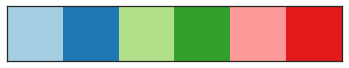

In [661]:
#sns.palplot(sns.color_palette("hls", 8))
sns.palplot(sns.color_palette("Paired"))
blue = sns.color_palette("Paired")[1]
green = sns.color_palette("Paired")[3]
red = sns.color_palette("Paired")[5]
redx = sns.color_palette("Paired")[4]

# Correlation Matrix

([<matplotlib.axis.YTick at 0x123962590>,
 <a list of 9 Text yticklabel objects>)

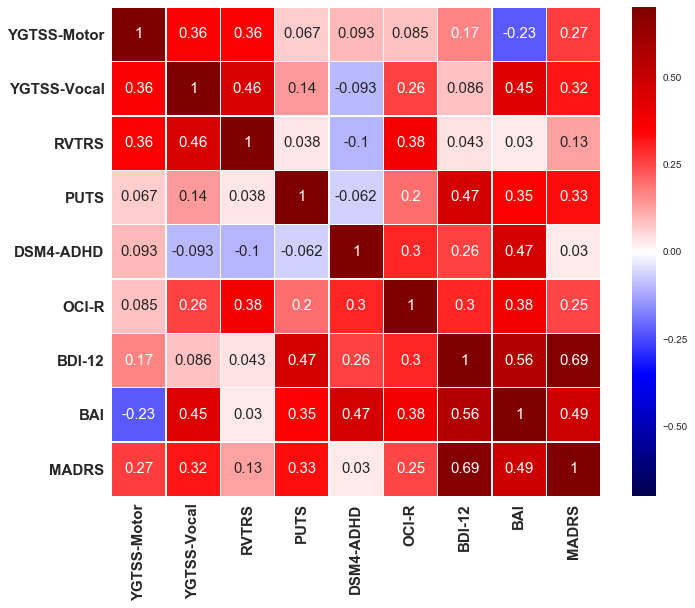

In [662]:
df = patients.drop([], axis = 0 )
cln_metrics = [df['CLN_YGTSS_Motoric_Score'],
               df['CLN_YGTSS_Vocal_Score'], 
               df['CLN_RVTRS'],
               df['CLN_puts'],
               #df['CLN_qol_score'],
               df['CLN_DSM4_ADHD_Score'], 
               #df['CLN_CAARS_Score_ADHS_Symptoms_Total_Cat_G_T_Score'], 
               #df['CLN_YBOCS_Totalscore_Items_1to10'],  
               df['CLN_OCIR_total_score'],
               df['CLN_BDI12'],  
               df['CLN_BAI'],  
               df['CLN_MADRS'],
              ]

df = pd.concat(cln_metrics,  axis=1)
corr = df.corr('spearman')
mask = np.zeros_like(corr, dtype=np.bool)
#mask[np.triu_indices_from(mask, k = 1)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
cmap = 'seismic'
sns.heatmap(corr, cmap = cmap ,
            mask=mask,square=True, vmin = -.7, vmax = .7,
            linewidths=.5, cbar_kws={"shrink": 1}, ax=ax, annot = True, annot_kws={"size":15})
ticks  =  [x + .5 for x in range(0,9)]
labelx = ['YGTSS-Motor', 'YGTSS-Vocal', 'RVTRS', 'PUTS','DSM4-ADHD', #'CAARS','Y-BOCS', 
          'OCI-R', 'BDI-12', 'BAI','MADRS']
plt.xticks(ticks, labelx, fontsize = 15, weight='bold')
plt.yticks(ticks[::-1], labelx, fontsize = 15, weight='bold')

#plt.savefig(os.path.join(save_fig_dir, 'cln_corr.png'), dpi = dpi, bbox_inches='tight', transparent = True)
    


# MOTOR Prinicpal Component

In [663]:
df = patients
PC_val = 'PC2'
df[PC_val] = df[PC_val] * -1
detect_outlier_subjects(df,PC_val,m=2)


-0.499 0.0366388


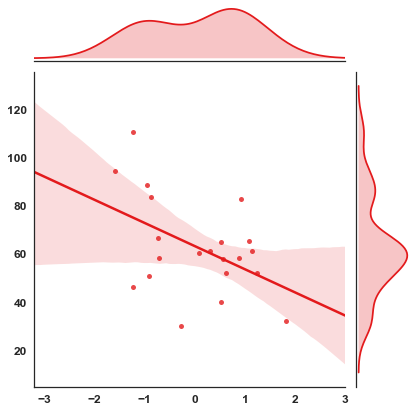

In [670]:
plot_partial_correlation(df.drop(['RMJP','HHQP'],axis=0), 
                         PC_val, 'ALL', 
                         xlim = (-3.2,3), 
                         ylim = None, regressors = ['Age','Gender', 'QC_PCA'], 
                         color = red, #annotate = (.23,0.3),
                         dpi = 100, labels = 0, jitter = 0.0001,fit_reg=True, scatter=1,
                         plot_marg = 1, ci = 95, lstyle='-',lw=2.5,
                         fig_name = 'clinical_PCA_chi_tics.png'
                        )

-0.556 0.0577647


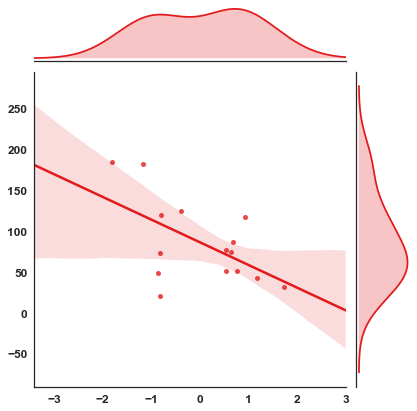

In [669]:
plot_partial_correlation(df.drop(['SA5U'],axis=0), 
                        'PC2', 'CLN_Ferritin', 
                         xlim = (-3.4,3), 
                         ylim = None, regressors = ['Age','Gender', 'QC_PCA'], 
                         color = red, #annotate = (.23,0.3),
                         dpi = 100, labels = 0, jitter = 0.01,fit_reg=True, scatter=1,
                         plot_marg = 1, ci = 95, lstyle='-',lw=2.5,
                         fig_name = 'clinical_PCA_chi_ferritin.png'
                        )

# Depression/Anxiety

SM6U
-0.343 0.173074


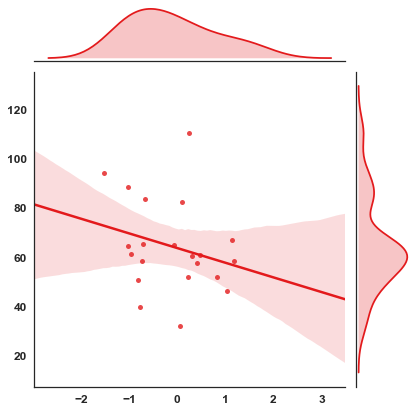

In [675]:
df = patients
df['PC1'] = df['PC1'] * -1

detect_outlier_subjects(df,'PC1',m=2)

plot_partial_correlation(df.drop(['SM6U'],axis=0), 
                        'PC1', 'ALL', 
                         xlim = None,#(-.6,.6), 
                         ylim = None, regressors = ['Age','Gender','QC_PCA'], 
                         color = red, #annotate = (.23,0.3),
                         dpi = 100, labels = 0, jitter = 0.0001,fit_reg=True, scatter=1,
                         plot_marg = 1, ci = 95, lstyle='-',lw=2.5,
                         #fig_name = 'clinical_PCA_chi_pc1.png'
                        )

-0.284 0.4706476


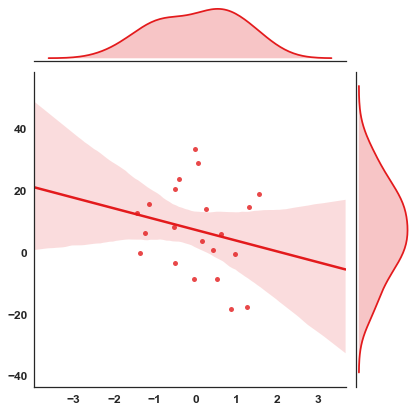

In [667]:
df = patients
df['PC3'] = df['PC3'] * -1

detect_outlier_subjects(df,'PC3',m=2)

plot_partial_correlation(df.drop(['HHQP'],axis=0), 
                        'PC3', 'Caud_Puta', 
                         xlim = None,#(-.6,.6), 
                         ylim = None, regressors = ['Age','Gender','QC_PCA'], 
                         color = red, #annotate = (.23,0.3),
                         dpi = 100, labels = 0, jitter = 0.0001,fit_reg=True, scatter=1,
                         plot_marg = 1, ci = 95, lstyle='-',lw=2.5,
                         #fig_name = 'clinical_PCA_chi_pc3.png'
                        )

-0.35 0.6038011


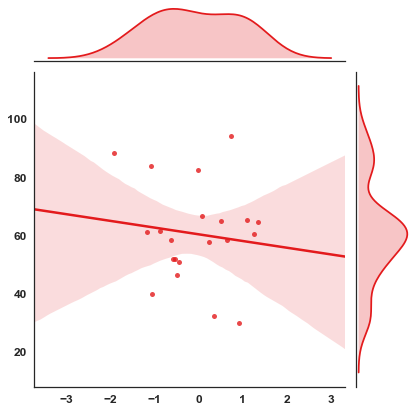

In [676]:
df = patients
df['PC4'] = df['PC4'] * -1

detect_outlier_subjects(df,'PC4',m=2)

plot_partial_correlation(df.drop(['RL7P'],axis=0), 
                        'PC4', 'ALL', 
                         xlim = None,#(-.6,.6), 
                         ylim = None, regressors = ['Age','Gender','QC_PCA'], 
                         color = red, #annotate = (.23,0.3),
                         dpi = 100, labels = 0, jitter = 0.0001,fit_reg=True, scatter=1,
                         plot_marg = 1, ci = 95, lstyle='-',lw=2.5,
                         #fig_name = 'clinical_PCA_chi_pc4.png'
                        )

In [544]:
loadings#.drop(['PC6', 'PC7','PC8','PC9'],axis=1).round(2)

,PC1,PC2,PC3,PC4
CLN_YGTSS_Motoric_Score,0.112675,0.794591,0.158293,0.009279
CLN_YGTSS_Vocal_Score,0.404262,0.601943,-0.195113,0.064719
CLN_RVTRS,-0.087644,0.707319,-0.037604,0.405440
CLN_puts,0.690772,0.018515,-0.088392,0.477693
CLN_YBOCS_Totalscore_Items_1to10,-0.043336,0.158302,-0.119905,0.890091
CLN_OCIR_total_score,0.316091,0.416049,0.415665,0.509183
CLN_DSM4_ADHD_Score,0.070107,-0.038615,0.771193,-0.103140
CLN_CAARS_Score_ADHS_Symptoms_Total_Cat_G_T_Score,0.320686,0.060622,0.842592,0.011783
CLN_BAI,0.840183,-0.059739,0.126483,0.048232
CLN_BDI12,0.858051,0.149210,0.343030,0.077979


In [545]:
explained_var = np.asarray([0.3734619, 0.1857209, 0.1102498, 0.1014939, 0.09165648, 
                            0.0676820,0.04388436, 0.01661871,0.009232003]) * 100
explained_var_num = range(1,10)


(array([ -5.,   0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.]),
 <a list of 10 Text yticklabel objects>)

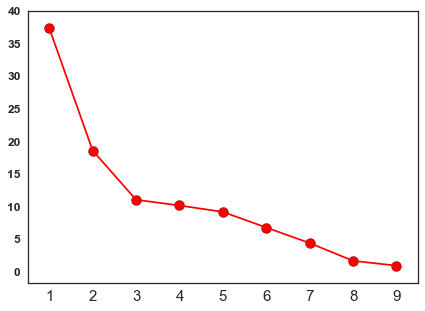

In [546]:
#sns.barplot(explained_var_num, explained_var, color="grey",linewidth=2.5, facecolor=(1, 1, 1, 0),errcolor=".2", edgecolor=".2")
sns.set_style('white')

fig, ax = plt.subplots(1)
fig.set_size_inches([7,5])

plt.plot(explained_var_num, explained_var, marker="o", markerfacecolor="r", c= 'r')
plt.scatter(explained_var_num, explained_var, s=100, facecolors='r', edgecolors='k')


plt.xticks(range(1,10), fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0.5,9.5)
plt.yticks(fontsize=12, weight='bold')
#sns.despine(left=alse, bottom=False)
#plt.savefig(os.path.join(save_fig_dir, 'exp_var.png'), dppi  = 100)

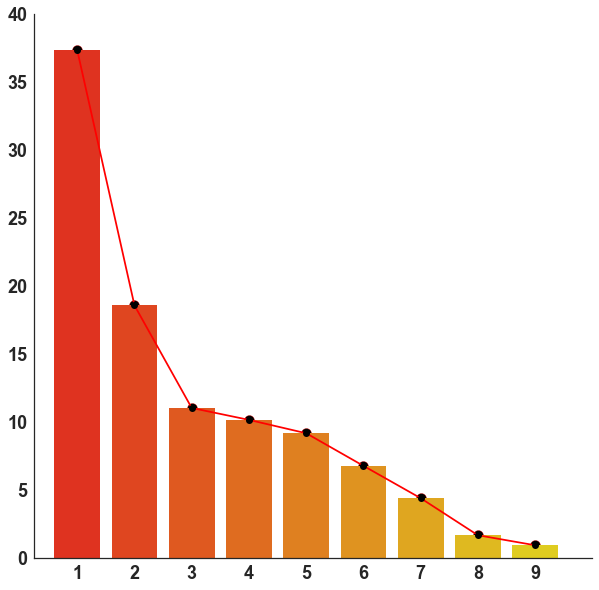

In [547]:
fig, ax = plt.subplots(1)
fig.set_size_inches([10,10])

sns.barplot(explained_var_num, explained_var, palette='autumn')
plt.plot(np.array(explained_var_num) - 1, explained_var, marker="o", markerfacecolor="k", c= 'r')
plt.scatter(np.array(explained_var_num) - 1, explained_var, s=100, facecolors='k', edgecolors='r')
plt.yticks(fontsize=12, weight='bold')
plt.xticks(fontsize=12, weight='bold')
plt.ylim(0,40)
plt.xlim(-0.75,9)
plt.tick_params(axis='y', direction='in', labelsize=18)
plt.tick_params(axis='x', direction='in', labelsize=18)
sns.despine(left=False, bottom=False)


plt.savefig(os.path.join(save_fig_dir, 'exp_var.png'), dppi  = 300, bbox_inches = 'tight')

[]

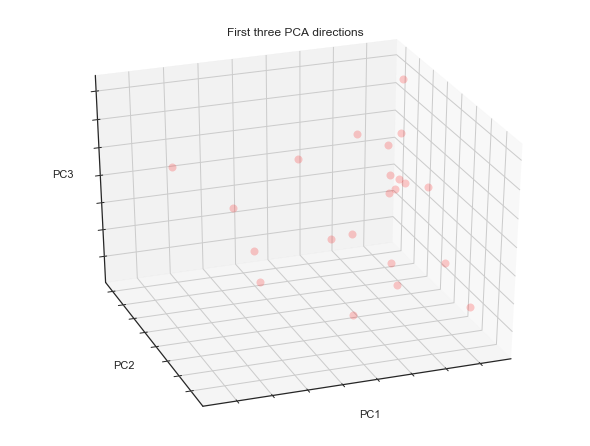

In [548]:
# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)

ax.plot(scores.PC1,scores.PC2,scores.PC3, 'o', markersize=8, color='red', alpha=0.2)

ax.set_title("First three PCA directions")
ax.set_xlabel("PC1")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("PC2")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("PC3")
ax.w_zaxis.set_ticklabels([])

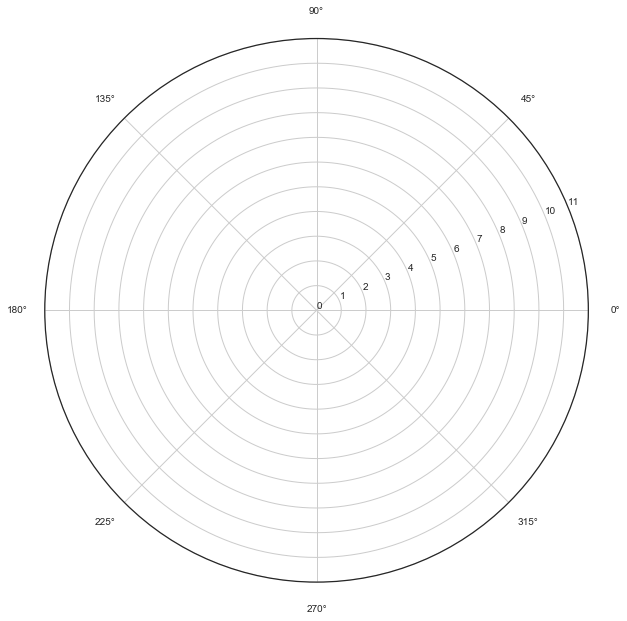

In [549]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='polar')
#ax.set_xticklabels(loadings.index)
ax.set_rticks(range(len(loadings.index)))
#ax.scatter(range(len(loadings.index)), loadings.PC1, )

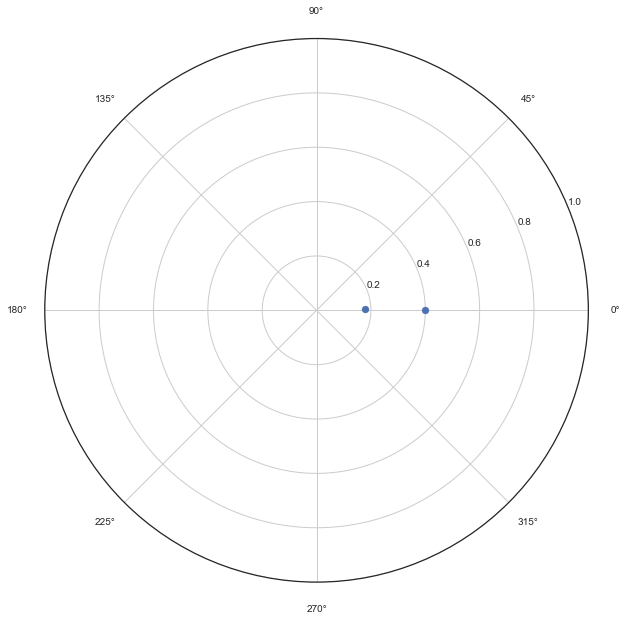

In [550]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111, projection='polar')
#bars = ax.bar(theta, radii)
ax.scatter([0,44], [0.4,0.18], linestyle='solid', zorder=3)
#ax.set_xticklabels(loadings.index)

#ax.set_rticks(range(len(loadings.index)))
ax.set_rmax(1)

In [554]:
loadings

,PC1,PC2,PC3,PC4
CLN_YGTSS_Motoric_Score,0.112675,0.794591,0.158293,0.009279
CLN_YGTSS_Vocal_Score,0.404262,0.601943,-0.195113,0.064719
CLN_RVTRS,-0.087644,0.707319,-0.037604,0.405440
CLN_puts,0.690772,0.018515,-0.088392,0.477693
CLN_YBOCS_Totalscore_Items_1to10,-0.043336,0.158302,-0.119905,0.890091
CLN_OCIR_total_score,0.316091,0.416049,0.415665,0.509183
CLN_DSM4_ADHD_Score,0.070107,-0.038615,0.771193,-0.103140
CLN_CAARS_Score_ADHS_Symptoms_Total_Cat_G_T_Score,0.320686,0.060622,0.842592,0.011783
CLN_BAI,0.840183,-0.059739,0.126483,0.048232
CLN_BDI12,0.858051,0.149210,0.343030,0.077979


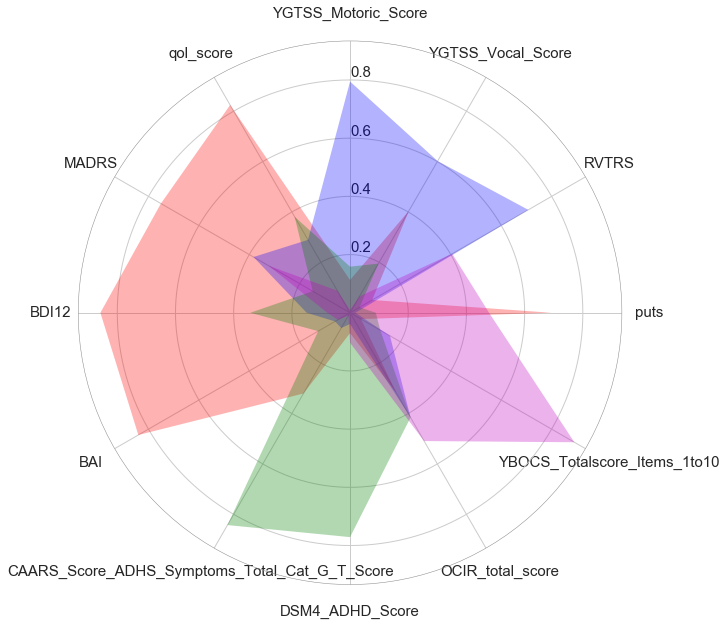

In [551]:
from math import pi
import matplotlib.pyplot as plt

# Set data
loadings = pd.read_csv(os.path.join(pheno_dir, 'pca_loadings.csv'),index_col = 0)

loading_index = [i[4:] for i in loadings.index]
cat = loading_index
values = list(loadings.PC1) # [90, 60, 65, 70, 40]
values2 = list(loadings.PC2) # [90, 60, 65, 70, 40]
values3 = list(loadings.PC3) # [90, 60, 65, 70, 40]
values4 = list(loadings.PC4) # [90, 60, 65, 70, 40]

N = len(cat)
x_as = [n / float(N) * 2 * pi for n in range(N)]

# Because our chart will be circular we need to append a copy of the first 
# value of each list at the end of each list with data
values.append(list(loadings.PC1)[0])
values = np.abs(np.array(values))

values2.append(list(loadings.PC2)[0])
values2 = np.abs(np.array(values2))

values3.append(list(loadings.PC3)[0])
values3 = np.abs(np.array(values3))

values4.append(list(loadings.PC4)[0])
values4 = np.abs(np.array(values4))

x_as += x_as_[:1]

# Set color of axes
plt.rc('axes', linewidth=0.5, edgecolor="#888888")

# Create polar plot
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111, polar=True)

# Set clockwise rotation. That is:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

#Set position of y-labels
ax.set_rlabel_position(0)

# Set color and linestyle of grid
#ax.xaxis.grid(True, color="#888888", linestyle='solid', linewidth=0.5)
#ax.yaxis.grid(True, color="#888888", linestyle='solid', linewidth=0.5)

# Set number of radial axes and remove labels
plt.xticks(x_as[:-1], loading_index)

# Set yticks
#plt.yticks([20, 40, 60, 80, 100], ["20", "40", "60", "80", "100"])

ax.fill(x_as, values, 'r', alpha=0.3)
ax.fill(x_as, values2, 'b', alpha=0.3)
ax.fill(x_as, values3, 'g', alpha=0.3)
ax.fill(x_as, values4, 'm', alpha=0.3)

plt.tick_params(axis='y', direction='in', labelsize=15)
plt.tick_params(axis='x', direction='in', labelsize=15)

In [552]:
values

array([ 0.11267549,  0.40426226,  0.08764431,  0.69077196,  0.04333598,
        0.31609058,  0.07010652,  0.32068574,  0.84018261,  0.85805097,
        0.75061374,  0.82437749,  0.11267549])

In [553]:
x_as

[0.0,
 0.5235987755982988,
 1.0471975511965976,
 1.5707963267948966,
 2.0943951023931953,
 2.6179938779914944,
 3.141592653589793,
 3.6651914291880923,
 4.1887902047863905,
 4.71238898038469,
 5.235987755982989,
 5.759586531581287,
 0.0]

In [78]:
from math import pi
import matplotlib.pyplot as plt

# Set data
loadings = pd.read_csv(os.path.join(pheno_dir, 'pca_loadings.csv'),index_col = 0)
cat = loadings.index#['Speed', 'Reliability', 'Comfort', 'Safety', 'Effieciency']
values_ = loadings.PC1 # [90, 60, 65, 70, 40]

N = len(cat)
x_as_ = [n / float(N) * 2 * pi for n in range(N)]

# Because our chart will be circular we need to append a copy of the first 
# value of each list at the end of each list with data
values += values_[:1]
x_as += x_as_[:1]
x_as

TypeError: unsupported operand type(s) for +: 'NoneType' and 'float'

In [70]:
x = list(loadings.PC1)#
x.append(list(loadings.PC1)[0])
x

[0.40098360212697604,
 0.11805875689610199,
 -0.065617779613601102,
 -0.0032977819895633302,
 0.45318905442678897,
 0.17013163143610802,
 0.47240465540118204,
 0.84302771882574101,
 0.91728258948230401]

In [75]:
from math import pi
import matplotlib.pyplot as plt

# Set data
loadings = pd.read_csv(os.path.join(pheno_dir, 'pca_loadings.csv'),index_col = 0)
cat = loadings.index#['Speed', 'Reliability', 'Comfort', 'Safety', 'Effieciency']
values = list(loadings.PC1) # [90, 60, 65, 70, 40]

N = len(cat)
x_as_ = [n / float(N) * 2 * pi for n in range(N)]

# Because our chart will be circular we need to append a copy of the first 
# value of each list at the end of each list with data
values = values.append(values[0])
x_as += x_as_[:1]

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

## import data
df = patients.drop([], axis = 0 )
cln_metrics = [df['CLN_YGTSS_Motoric_Score'],
               df['CLN_YGTSS_Vocal_Score'], 
               df['CLN_RVTRS'],
               df['CLN_puts'],
               #df['CLN_qol_score'],
               df['CLN_DSM4_ADHD_Score'], 
               #df['CLN_CAARS_Score_ADHS_Symptoms_Total_Cat_G_T_Score'], 
               #df['CLN_YBOCS_Totalscore_Items_1to10'],  
               df['CLN_OCIR_total_score'],
               df['CLN_BDI12'],  
               df['CLN_BAI'],  
               df['CLN_MADRS'],
              ]

df = pd.concat(cln_metrics,  axis=1)
dat = df
# if no row or column titles in your csv, pass 'header=None' into read_csv
# and delete 'index_col=0' -- but your biplot will be clearer with row/col names

## perform PCA
n = len(dat.columns)
pca = PCA(n_components = n)
# defaults number of PCs to number of columns in imported data (ie number of
# features),but can be set to any integer less than or equal to that value
pca.fit(dat)

## project data into PC space
# 0,1 denote PC1 and PC2; change values for other PCs
xvector = pca.components_[0] # see 'prcomp(my_data)$rotation' in R
yvector = pca.components_[1]

xs = pca.transform(dat)[:,0] # see 'prcomp(my_data)$x' in R
ys = pca.transform(dat)[:,1]

## visualize projections
    
## Note: scale values for arrows and text are a bit inelegant as of now,
##       so feel free to play around with them

LOAD = np.asanyarray([loadings.PC1, loadings.PC2, loadings.PC3])

#for i in range(len(loadings.PC1)):
#arrows project features (ie columns from csv) as vectors onto PC axes
    #plt.arrow(0, 0, loadings.PC1.values, loadings.PC2.values,
    #          color='r', width=0.0005, head_width=0.0025)
    #plt.text(xvector[i]*max(xs)*1.2, yvector[i]*max(ys)*1.2,
    #         list(dat.columns.values)[i], color='r')

for i in range(len(scores.PC1)):
# circles project documents (ie rows from csv) as points onto PC axes
    plt.plot(scores.PC1, scores.PC2, 'ro')
    #plt.text(xs[i]*1.2, ys[i]*1.2, list(dat.index)[i], color='b')

plt.show()

In [19]:
loadings.PC2.values

array([ 0.70932124,  0.50828151,  0.79308859, -0.04651209,  0.09360316,
        0.64809557, -0.1342655 ,  0.118144  ,  0.13861481])

Populating the interactive namespace from numpy and matplotlib


/Users/kanaan/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'pi']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


NameError: name 'all_samples' is not defined

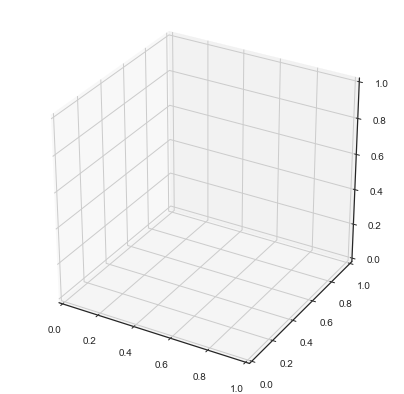

In [20]:
%pylab inline

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch


class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(all_samples[0,:], all_samples[1,:], all_samples[2,:], 'o', markersize=8, color='green', alpha=0.2)
ax.plot([mean_x], [mean_y], [mean_z], 'o', markersize=10, color='red', alpha=0.5)
for v in eig_vec_sc.T:
    a = Arrow3D([mean_x, v[0]], [mean_y, v[1]], [mean_z, v[2]], mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
    ax.add_artist(a)
ax.set_xlabel('x_values')
ax.set_ylabel('y_values')
ax.set_zlabel('z_values')

plt.title('Eigenvectors')

plt.show()

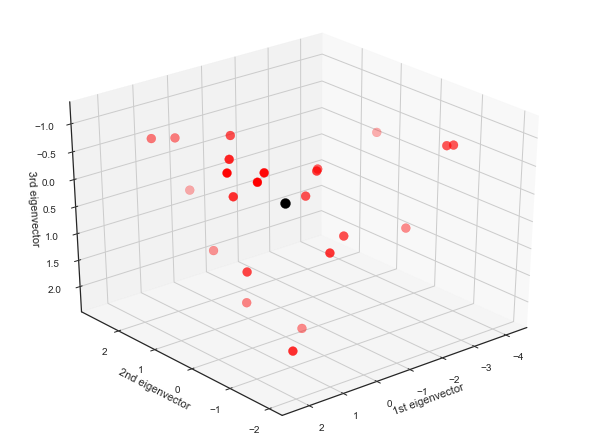

In [54]:
# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=130)
ax.scatter(scores.PC1, scores.PC2, scores.PC3, color='red', s=80)
ax.scatter(0,0,0, color='k', s=100)
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")
ax.set_zlabel("3rd eigenvector")



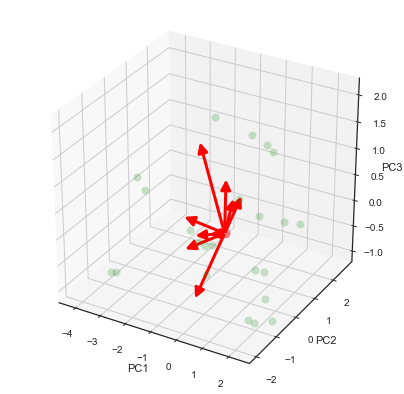

In [85]:
mean_x = np.mean(scores.PC1.round(2)) 
mean_y = np.mean(scores.PC2.round(2)) 
mean_z = np.mean(scores.PC3.round(2))

mean_vector = np.array([[mean_x],[mean_y],[mean_z]])

#print('Mean Vector:\n', mean_vector)

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch


class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(scores.PC1,scores.PC2,scores.PC3, 'o', markersize=8, color='green', alpha=0.2)
ax.plot([mean_x], [mean_y], [mean_z], 'o', markersize=10, color='red', alpha=0.5)

LOAD = np.asanyarray([loadings.PC1, loadings.PC2, loadings.PC3])

for v in LOAD.T * 2.5:
    a = Arrow3D([mean_x, v[0]] , 
                [mean_y, v[1]], 
                [mean_z, v[2]], 
                mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
    ax.add_artist(a)
    #plt.text(xvector[i]*max(xs)*1.2, yvector[i]*max(ys)*1.2,
    #         list(dat.columns.values)[i], color='r')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')



In [76]:
max(loadings.PC1)

-0.14596964078867902

In [77]:

LOAD = np.asanyarray([loadings.PC1, loadings.PC2, loadings.PC3])

for v in LOAD:
    print v *max(loadings.PC1)

[ 0.03487286  0.04289028  0.02500061  0.05160029  0.02130714  0.04832998
  0.05774585  0.07083085  0.06182597]
[-0.07165715 -0.0582758  -0.08329069  0.02277645  0.04423576 -0.01195091
  0.04701108  0.02945214  0.0119632 ]
[-0.01200297 -0.03709179 -0.01218145  0.07559804 -0.11240093  0.01240326
 -0.02710835  0.01863195  0.00734786]


In [75]:
mean_z*100

0.08695652173913147